# Global Stiffness

The goal is to develop code that will perform a robust truss analysis based on global stiffness methods from matrix structural analysis to allow the solution method to generalize.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [12]:
img_path = 'truss1.png'

In [14]:
img = mpimg.imread(img_path, 0)

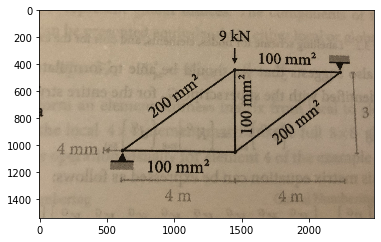

In [15]:
plt.imshow(img)

Consider the truss shown above to test implementation of the solution. For all elements, E = 200,000 MPa.

Note that the truss has both applied loads and a specified nonzero displacement at a joint.

For any given structure, the size of the global stiffness matrix will be governed by the degrees of freedom. In general, without regard to fixed joints with zero DOF, the global stiffness matrix will have two degrees of freedom per joint/node, so the truss shown will have an 8x8 global stiffness matrix. 

The full matrix equation for the structure would be:

$$ [F^G]_{8x1} = [K^G]_{8x8} [d^G]_{8x1} $$

where is the vector of forces, and d is the vector of displacements.

We want to adjust Ke_truss so that it computes an element's length and orientation based on it being passed nodal coordinates in the form (x1, y1), (x2, y2)

In [16]:
def Ke_truss_single(coords, prop):
    ''' Generate the truss element stiffness matrix.
    Inputs
    ------
    
    xe: list of component-lengths for truss element. For example, a 5m member inclined at 32.9 deg will have
    xe elements of 4m and 3m. The same member inclined at zero degrees will have 5m and 0m.
    prop: list of properties [Young's modulus, cross-sectional area]
    '''
    L = np.linalg.norm(coords)
    nx = (coords[1, 0] - coords[0, 0]) / L
    ny = (coords[1, 1] - coords[0, 1]) / L
    T = np.zeros((2, 4), dtype=np.float32)
    T[0, :2] = [nx, ny]
    T[1, 2:] = [nx, ny]
    E, A = prop[0], prop[1]
    
    # Local stiffness matrix
    k = np.array([[1., -1.], [1., -1.]])
    k *= E*A/L
    
    # Global element stiffness matrix
    Ke = T.T @ k @ T
    
    return Ke

Let's test Ke_truss operating on a single element by passing it the node coordinates and the properties.

In [17]:
coords = np.array([[0., 0.], [4000., 0.]])
prop = [200000., 100.]

In [18]:
Ke_truss_single(coords, prop)

array([[ 5000.,     0., -5000.,     0.],
       [    0.,     0.,     0.,     0.],
       [ 5000.,     0., -5000.,     0.],
       [    0.,     0.,     0.,     0.]])

This produces the expected results. What we now want is to be able to pass the function the entire set of coordinates, along with the nodes that define the element, using an index of element nodes (ied). This will allow us to loop through the nodes and develop all global element stiffniss matrices at once.

In [19]:
def Ke_truss(coords, prop, ien, elem_idx):
    ''' Generate the truss element stiffness matrix.
    Inputs
    ------
    
    xe: list of component-lengths for truss element. For example, a 5m member inclined at 32.9 deg will have
    xe elements of 4m and 3m. The same member inclined at zero degrees will have 5m and 0m.
    prop: list of properties [Young's modulus, cross-sectional area]
    '''
    # elem_idx -= 1 # adjusting for element numberings that begin with 1
    nx = (coords[ien[elem_idx, 1], 0] - coords[ien[elem_idx, 0], 0])
    ny = (coords[ien[elem_idx, 1], 1] - coords[ien[elem_idx, 0], 1])
    #print(nx, ny)
    L = np.linalg.norm([nx, ny])
    #print(L)
    T = np.zeros((2, 4), dtype=np.float32)
    T[0, :2] = [nx, ny] / L
    T[1, 2:] = [nx, ny] / L
    #print(T)
    E = prop[elem_idx, 0]
    A = prop[elem_idx, 1]
    
    # Local stiffness matrix
    k = np.array([[1., -1.], [-1., 1.]])
    k *= E*A/L
    
    # Global element stiffness matrix
    Ke = T.T @ k @ T
    
    return Ke

Let's now develop the entire coordinate matrix, and the entire ien matrix, and pass the function the element nodes associated with the member from the previous section to test the results.

In [20]:
coords = np.array([[0, 0], [4000, 0], [4000, 3000], [8000, 3000]], dtype=np.float32)

In [21]:
coords

array([[   0.,    0.],
       [4000.,    0.],
       [4000., 3000.],
       [8000., 3000.]], dtype=float32)

In [22]:
ien = np.array([[0, 1], [0, 2], [1, 2], [1, 3], [2, 3]])

In [23]:
ien

array([[0, 1],
       [0, 2],
       [1, 2],
       [1, 3],
       [2, 3]])

In [24]:
Ke_truss(coords, prop, ien, elem_idx=0)

TypeError: list indices must be integers or slices, not tuple

Now, we shold be able to collect all global stiffness matrices via a for loop.

In [25]:
prop = np.array([[200000., 100.], [200000., 200.], [200000., 100.], [200000., 200.], [200000., 100.]])

In [26]:
prop

array([[2.e+05, 1.e+02],
       [2.e+05, 2.e+02],
       [2.e+05, 1.e+02],
       [2.e+05, 2.e+02],
       [2.e+05, 1.e+02]])

In [27]:
Ke = []
for i in range(len(ien)):
    K = Ke_truss(coords, prop, ien, i)
    Ke.append(K)

In [28]:
Ke

[array([[ 5000.,     0., -5000.,     0.],
        [    0.,     0.,     0.,     0.],
        [-5000.,     0.,  5000.,     0.],
        [    0.,     0.,     0.,     0.]]),
 array([[ 5120.00015259,  3840.00020981, -5120.00015259, -3840.00020981],
        [ 3840.00020981,  2880.00022888, -3840.00020981, -2880.00022888],
        [-5120.00015259, -3840.00020981,  5120.00015259,  3840.00020981],
        [-3840.00020981, -2880.00022888,  3840.00020981,  2880.00022888]]),
 array([[    0.        ,     0.        ,     0.        ,     0.        ],
        [    0.        ,  6666.66666667,     0.        , -6666.66666667],
        [    0.        ,     0.        ,     0.        ,     0.        ],
        [    0.        , -6666.66666667,     0.        ,  6666.66666667]]),
 array([[ 5120.00015259,  3840.00020981, -5120.00015259, -3840.00020981],
        [ 3840.00020981,  2880.00022888, -3840.00020981, -2880.00022888],
        [-5120.00015259, -3840.00020981,  5120.00015259,  3840.00020981],
        [-38

These results are as expected. We now want to assemble the global stiffness matrix, and for that we will need the degrees of freedom for the system. A simple way to do this is to create a matrix holding the degrees of freedom for each element. Let's call this the index of element DOF, ied. We should make up a nodal DOF matrix to construct the ien from.

In [29]:
n_nodes = 4
ind = np.zeros((n_nodes, 2))
for i in range(n_nodes):
    ind[i, 0] = i * 2
    ind[i, 1] = i * 2 + 1

In [30]:
ind

array([[0., 1.],
       [2., 3.],
       [4., 5.],
       [6., 7.]])

In [31]:
ied = np.zeros((len(ien), 2, 2), dtype=np.int8)

In [32]:
for i in range(len(ien)):
    ied[i, 0] = ind[ien[i, 0]]
    ied[i, 1] = ind[ien[i, 1]]

In [33]:
ied

array([[[0, 1],
        [2, 3]],

       [[0, 1],
        [4, 5]],

       [[2, 3],
        [4, 5]],

       [[2, 3],
        [6, 7]],

       [[4, 5],
        [6, 7]]], dtype=int8)

This code should now be compiled in a function that creates the index of element degrees of freedom, which will then be used to create the global stiffness matrix by assembling the global element stiffness matrices.

The method attemped will be to iterate over a Ke matrix, sending each entry to the /location indicated in ied.

In [34]:
KG = np.zeros((n_nodes * 2, n_nodes * 2))

In [35]:
n_elements = 1
for element in range(n_elements):
    for row in range(4):
        for col in range(4):
            idx = ied[element].flatten()
            KG[idx[row], idx[col]] += Ke[element][row, col]

In [36]:
KG

array([[ 5000.,     0., -5000.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [-5000.,     0.,  5000.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.]])

It appears to have worked for the first element. Let's iterate over all elements and see what the results are:

In [37]:
KG = np.zeros((n_nodes * 2, n_nodes * 2))
n_elements = 5
for element in range(n_elements):
    for row in range(4):
        for col in range(4):
            idx = ied[element].flatten()
            KG[idx[row], idx[col]] += Ke[element][row, col]

In [38]:
KG

array([[10120.00015259,  3840.00020981, -5000.        ,     0.        ,
        -5120.00015259, -3840.00020981,     0.        ,     0.        ],
       [ 3840.00020981,  2880.00022888,     0.        ,     0.        ,
        -3840.00020981, -2880.00022888,     0.        ,     0.        ],
       [-5000.        ,     0.        , 10120.00015259,  3840.00020981,
            0.        ,     0.        , -5120.00015259, -3840.00020981],
       [    0.        ,     0.        ,  3840.00020981,  9546.66689555,
            0.        , -6666.66666667, -3840.00020981, -2880.00022888],
       [-5120.00015259, -3840.00020981,     0.        ,     0.        ,
        10120.00015259,  3840.00020981, -5000.        ,     0.        ],
       [-3840.00020981, -2880.00022888,     0.        , -6666.66666667,
         3840.00020981,  9546.66689555,     0.        ,     0.        ],
       [    0.        ,     0.        , -5120.00015259, -3840.00020981,
        -5000.        ,     0.        , 10120.00015259,  3

In [39]:
len(Ke)

5

In [40]:
def KG_truss(Ke, n_nodes, ien):
    ''' Assemble the global stiffness matrix from a tensor of the element stiffness matrices.
    For this 2D code, each element is associated with 2 nodes at each end. The tensor of 
    element stiffness matrices is of shape (num_elements, dof, dof) where dof is the number
    of degrees of freedom per element (4 in this case).
    '''
    n_elements = len(Ke)
    # develop a matrix of indices of node degrees of freedom
    ind = np.zeros((n_nodes, 2), dtype=np.int8)
    for i in range(n_nodes):
        ind[i, 0] = i * 2
        ind[i, 1] = i * 2 + 1
        
    # develop a matrix of indices of element degrees of freedom by iterating over the 
    # indices of node DOF. This maps the DOF associated with each node to each element.
    # Each entry along axis 0 is an element
    ied = np.zeros((len(ien), 2, 2), dtype=np.int8)
    for i in range(len(ien)):
        ied[i, 0] = ind[ien[i, 0]]
        ied[i, 1] = ind[ien[i, 1]]
        
    KG = np.zeros((n_nodes * 2, n_nodes * 2))
    # assigning the entries of Ke to the locations in KG corresponding to the DOF at each
    # node in the element.
    for element in range(n_elements):
        for row in range(4):
            for col in range(4):
                idx = ied[element].flatten()
                KG[idx[row], idx[col]] += Ke[element][row, col]
    return KG

In [41]:
KG_truss(Ke, 4, ien)

array([[10120.00015259,  3840.00020981, -5000.        ,     0.        ,
        -5120.00015259, -3840.00020981,     0.        ,     0.        ],
       [ 3840.00020981,  2880.00022888,     0.        ,     0.        ,
        -3840.00020981, -2880.00022888,     0.        ,     0.        ],
       [-5000.        ,     0.        , 10120.00015259,  3840.00020981,
            0.        ,     0.        , -5120.00015259, -3840.00020981],
       [    0.        ,     0.        ,  3840.00020981,  9546.66689555,
            0.        , -6666.66666667, -3840.00020981, -2880.00022888],
       [-5120.00015259, -3840.00020981,     0.        ,     0.        ,
        10120.00015259,  3840.00020981, -5000.        ,     0.        ],
       [-3840.00020981, -2880.00022888,     0.        , -6666.66666667,
         3840.00020981,  9546.66689555,     0.        ,     0.        ],
       [    0.        ,     0.        , -5120.00015259, -3840.00020981,
        -5000.        ,     0.        , 10120.00015259,  3

These results are good. We now want to partition the matrix based on what is known and what is unknown. In this case, we know 4 displacements and one force. Perhaps a displacement list of known values and unknown values will help partitioning:

In [42]:
u = np.array([-4., 0., 'unk', 'unk', 'unk', 'unk', 0., 0.]) # displacement vector

In [43]:
P = np.array(['unk', 'unk', 0, 0, 0, -9000, 'unk', 'unk'])  # force vector

In [44]:
uP = np.concatenate((u, P), axis=0)
uP.shape

(16,)

In [45]:
for i in range(uP.shape[1]):
    if uP[1, i] == 'unk':
        for j in range(uP.shape[1] - 1, i, -1):
            if uP[1, j] != 'unk':
                uP[:, i], uP[:, j] = uP[:, j], uP[:, i]
                print("Swapped! i: {}, j: {}".format(i, j))
                break

IndexError: tuple index out of range

The above sorting algorithm properly exchanges list entries such that the unknown values are moved to the bottom. Perhaps by concatenating the force vector, displacement vector, and global stiffness matrix, the rows can be rearranged based on sorting the displacement list for partitioning. 

Matrix needs to be partitioned such that the natural boundary conditions are on top, that is those boundary conditions with known applied loads but unknown displacements. The essential boundary conditions, those with unknown loads (reaction forces) but known displacements, are moved to the bottom.

We could potentially also track the indices where there are known forces, and swap that way as well.

In [46]:
Pmask = P != 'unk'

In [47]:
Pmask

array([False, False,  True,  True,  True,  True, False, False])

In [48]:
np.where(P!='unk')

(array([2, 3, 4, 5]),)

In [49]:
U_idx = np.where(P!='unk')
S_idx = np.where(P=='unk')

In [50]:
np.concatenate((P[U_idx], P[S_idx]))

array(['0', '0', '0', '-9000', 'unk', 'unk', 'unk', 'unk'], dtype='<U5')

In [51]:
P[S_idx].shape

(4,)

In [52]:
K_test = np.arange(16).reshape((4,4))

In [53]:
test_idx = np.array([3, 0, 2, 1])

In [54]:
K_test

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [55]:
K_test[test_idx]

array([[12, 13, 14, 15],
       [ 0,  1,  2,  3],
       [ 8,  9, 10, 11],
       [ 4,  5,  6,  7]])

This appears to be a better way to partition the global stiffness matrix and force/displacement vectors. From there, the active stiffness equation can be solved to yield the unknown displacements:

$$\begin{bmatrix} P_U  \\ R_S \end{bmatrix} = \begin{bmatrix} K_{UU} & K_{US}  \\ K_{SU} & K_{SS} \end{bmatrix} \ 
\begin{bmatrix} d_U  \\ d_S \end{bmatrix}$$

$$ P_U = [K_{UU}]d_U + [K_{US}]d_S $$

I think simply using the indices on a matrix will pick out particular rows and columns. Partitioning K_test above by taking rows and columns 0 and 1:

In [56]:
test_idx = np.array([0, 1])

In [57]:
K_test[np.ix_(test_idx,test_idx)]

array([[0, 1],
       [4, 5]])

In [58]:
def partition(KG, P, u):
    ''' Partition the stiffness matrix based on the DOF locations of the known forces. 
    Degrees of freedom containing unknown forces or displacements should contain the string "unk"
    '''
    # Indices for natural and essential boundary conditions, respectively.
    U_idx = P != 'unk'
    S_idx = P == 'unk'
    
    Pu = P[U_idx]
    du = u[U_idx]
    ds = u[S_idx]
    Kuu = KG[np.ix_(U_idx, U_idx)]
    Kus = KG[np.ix_(U_idx, S_idx)]
    Ksu = KG[np.ix_(S_idx, U_idx)]
    Kss = KG[np.ix_(S_idx, S_idx)]
    
    return Pu.astype(np.float32), ds.astype(np.float32), Kuu, Kus, Ksu, Kss

In [59]:
Pu, ds, Kuu, Kus, Ksu, Kss = partition(KG, P, u)

In [60]:
ds

array([-4.,  0.,  0.,  0.], dtype=float32)

In [61]:
partition(KG, P, u)

(array([    0.,     0.,     0., -9000.], dtype=float32),
 array([-4.,  0.,  0.,  0.], dtype=float32),
 array([[10120.00015259,  3840.00020981,     0.        ,     0.        ],
        [ 3840.00020981,  9546.66689555,     0.        , -6666.66666667],
        [    0.        ,     0.        , 10120.00015259,  3840.00020981],
        [    0.        , -6666.66666667,  3840.00020981,  9546.66689555]]),
 array([[-5000.        ,     0.        , -5120.00015259, -3840.00020981],
        [    0.        ,     0.        , -3840.00020981, -2880.00022888],
        [-5120.00015259, -3840.00020981, -5000.        ,     0.        ],
        [-3840.00020981, -2880.00022888,     0.        ,     0.        ]]),
 array([[-5000.        ,     0.        , -5120.00015259, -3840.00020981],
        [    0.        ,     0.        , -3840.00020981, -2880.00022888],
        [-5120.00015259, -3840.00020981, -5000.        ,     0.        ],
        [-3840.00020981, -2880.00022888,     0.        ,     0.        ]]),
 arr

In [62]:
def solve_du(Kuu, Pu, Kus, ds):
    return np.linalg.inv(Kuu) @ (Pu - Kus @ ds)

In [63]:
du = solve_du(Kuu, Pu, Kus, ds)

This is working correctly! So now, transfer the code into a .py script, and create a class to have methods perform all of the functionality above.

In [64]:
def solve_Rs(Ksu, du, Kss, ds):
    return Ksu @ du + Kss @ ds

In [65]:
du

array([-1.08714288, -2.34325871, -0.51285718, -3.98174088])

In [66]:
solve_Rs(Ksu, du, Kss, ds)

array([-17128.57154568,  -1923.21448915,  17128.57154568,  10923.21448915])

# Testing the MSA class from the script file MSA.py

In [98]:
import msa

In [99]:
my_msa = msa.MSA_truss(coords, ien, prop, u, P)

ValueError: could not convert string to float: 'unk'